In [1]:
import pandas as pd
import pathlib as Path
import requests
from dotenv import load_dotenv
import os 
import pyfolio as py
import yfinance as yf
import alpaca_trade_api as tradeapi
import numpy as np
import ta
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from MCForecastTools import MCSimulation
import hvplot.pandas
import empyrical
import quantstats as qs
%matplotlib inline

C:\Users\rrose\anaconda3\envs\dev\Lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
C:\Users\rrose\anaconda3\envs\dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\rrose\anaconda3\envs\dev\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
alpaca_api_key = os.getenv("alpaca_api_key")
alpaca_secret_key = os.getenv("alpaca_secret_key")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [4]:
tickers = ["XLF","XLY","VGT","XLE"]
timeframe= "1Day"
start_date= pd.Timestamp("2017-01-01", tz="America/New_York").isoformat()
end_date= pd.Timestamp("2023-11-07", tz="America/New_York").isoformat()
expansion_etf_portfolio = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

expansion_etf_portfolio.head()

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2017-01-03 05:00:00+00:00,122.46,123.1144,121.7300,2787,122.29,436375,122.162019,VGT
2017-01-04 05:00:00+00:00,123.20,123.3783,122.6100,2784,122.61,448513,123.123947,VGT
2017-01-05 05:00:00+00:00,123.29,123.7500,122.8700,2365,123.04,581164,123.246415,VGT
2017-01-06 05:00:00+00:00,124.42,124.6900,123.1000,2579,123.36,393050,124.115234,VGT
2017-01-09 05:00:00+00:00,124.64,124.9800,124.4601,2230,124.55,322797,124.739436,VGT


In [5]:
# Format expansion data
xlf = expansion_etf_portfolio[expansion_etf_portfolio["symbol"]=="XLF"].drop("symbol", axis=1)
xly = expansion_etf_portfolio[expansion_etf_portfolio["symbol"]=="XLY"].drop("symbol", axis=1)
vgt = expansion_etf_portfolio[expansion_etf_portfolio["symbol"]=="VGT"].drop("symbol", axis=1)
xle = expansion_etf_portfolio[expansion_etf_portfolio["symbol"]=="XLE"].drop("symbol", axis=1)

expansion_etf_portfolio = pd.concat([xlf, xly, vgt, xle], axis=1, keys=["XLF", "XLY", "VGT", "XLE"])
expansion_etf_portfolio.head()

XLF                                               \
                           close     high    low trade_count   open    volume   
timestamp                                                                       
2017-01-03 05:00:00+00:00  23.51  23.6700  23.26       76376  23.61  73412822   
2017-01-04 05:00:00+00:00  23.70  23.7300  23.51       56418  23.58  47098033   
2017-01-05 05:00:00+00:00  23.46  23.6550  23.24       68217  23.63  64560019   
2017-01-06 05:00:00+00:00  23.54  23.6400  23.42       53170  23.55  38514463   
2017-01-09 05:00:00+00:00  23.38  23.5257  23.33       46724  23.48  34704527   

                                        XLY                ...     VGT  \
                                vwap  close   high    low  ...    open   
timestamp                                                  ...           
2017-01-03 05:00:00+00:00  23.460326  81.88  82.34  81.38  ...  122.29   
2017-01-04 05:00:00+00:00  23.635364  82.97  83.06  82.16  ...  122.61   
2017-01-05 05:00:00+00:00  23.436907  82.91  82.94  82.44  ...  123.04   
2017-01-06 05:00:00+00:00  23.551799  83.32  83.57  82.58  ...  123.36   
2017-01-09 05:00:00+00:00  23.426924  83.25  83.47  83.10  ...  124.55   

                                                   XLE                   \
                           volume        vwap    close    high      low   
timestamp                                                                 
2017-01-03 05:00:00+00:00  436375  122.162019  76.1708  76.810  75.3600   
2017-01-04 05:00:00+00:00  448513  123.123947  76.0100  76.370  75.7600   
2017-01-05 05:00:00+00:00  581164  123.246415  75.8200  76.340  75.4574   
2017-01-06 05:00:00+00:00  393050  124.115234  75.8900  76.145  75.3925   
2017-01-09 05:00:00+00:00  322797  124.739436  74.7900  75.460  74.6800   

                                                                   
                          trade_count   open    volume       vwap  
timestamp                                                          
2017-01-03 05:00:00+00:00       95724  76.11  26276256  76.099165  
2017-01-04 05:00:00+00:00       54158  76.23  12659155  76.016949  
2017-01-05 05:00:00+00:00       58348  76.06  12516548  75.906351  
2017-01-06 05:00:00+00:00       48237  76.06   7513810  75.875262  
2017-01-09 05:00:00+00:00       67393  75.39  11405566  74.909614  

[5 rows x 28 columns]

In [6]:
# Trim data
expansion_etf_portfolio_close = pd.DataFrame()

for ticker in tickers:
    expansion_etf_portfolio_close[ticker] = expansion_etf_portfolio[ticker]["close"]
    
expansion_etf_portfolio_close.index = expansion_etf_portfolio_close.index.date

expansion_etf_portfolio_returns = expansion_etf_portfolio_close.pct_change()
expansion_etf_portfolio_close.head()

,XLF,XLY,VGT,XLE
2017-01-03,23.51,81.88,122.46,76.1708
2017-01-04,23.70,82.97,123.20,76.0100
2017-01-05,23.46,82.91,123.29,75.8200
2017-01-06,23.54,83.32,124.42,75.8900
2017-01-09,23.38,83.25,124.64,74.7900


In [7]:
?MCSimulation

Init signature:
MCSimulation(
    portfolio_data,
    weights='',
    num_simulation=1000,
    num_trading_days=252,
)
Docstring:     
A Python class for runnning Monte Carlo simulation on portfolio price data. 

...

Attributes
----------
portfolio_data : pandas.DataFrame
    portfolio dataframe
weights: list(float)
    portfolio investment breakdown
nSim: int
    number of samples in simulation
nTrading: int
    number of trading days to simulate
simulated_return : pandas.DataFrame
    Simulated data from Monte Carlo
confidence_interval : pandas.Series
    the 95% confidence intervals for simulated final cumulative returns
    
Init docstring:
Constructs all the necessary attributes for the MCSimulation object.

Parameters
----------
portfolio_data: pandas.DataFrame
    DataFrame containing stock price information from Alpaca API
weights: list(float)
    A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
num_simulation: int
    Number 

In [8]:
MC_fiveyear = MCSimulation(
    portfolio_data = expansion_etf_portfolio,
    weights = [.30,.30,.30,.30],
    num_simulation = 250,
    num_trading_days = 252*5
)

In [9]:
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 110.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 120.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 130.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 140.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 150.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 160.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 170.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 180.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 190.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 200.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 210.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 220.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 230.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 240.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002998,0.992458,1.001228,0.990386,0.998194,0.993721,1.017467,1.021386,1.013845,1.016785,...,1.011166,0.996903,1.008045,0.990397,0.988839,1.012888,0.987975,0.998059,0.993327,1.019082
2,1.015670,1.013550,1.002285,0.992643,0.986955,1.001916,1.013200,1.019720,1.004225,1.032542,...,1.004989,0.992658,1.002299,0.991664,0.984115,1.026641,0.992869,1.003306,0.989986,1.007529
3,1.001055,1.030515,1.006744,1.008145,0.983669,0.991730,1.005124,1.024637,1.005469,1.021929,...,1.006292,0.993311,0.991929,0.988065,0.991866,1.035836,0.996857,0.999324,1.002212,1.031868
4,1.002470,1.016249,1.008492,1.005356,0.977153,0.983809,1.016298,1.031954,1.008256,1.017394,...,0.999031,0.983668,0.995334,0.979571,1.005587,1.040528,0.989085,0.997587,1.010106,1.036809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.086410,3.143979,1.301888,4.872007,1.522154,2.001394,1.916284,2.340686,2.021571,2.772589,...,2.266971,1.579397,1.594422,1.934752,1.632240,2.713163,1.352352,0.949268,1.943133,2.187207
1257,1.077778,3.140922,1.285780,4.946329,1.520896,2.023777,1.910515,2.331203,2.019981,2.708441,...,2.266116,1.556830,1.569228,1.963078,1.657368,2.724231,1.344340,0.950985,1.953614,2.186642
1258,1.076788,3.109941,1.289202,5.027725,1.507826,2.018925,1.891823,2.322421,2.014866,2.741826,...,2.289101,1.558516,1.572301,1.997415,1.650254,2.783171,1.351186,0.961038,1.965625,2.206240
1259,1.081838,3.123776,1.293416,5.026868,1.516795,2.045895,1.863901,2.357978,2.026153,2.740344,...,2.231557,1.552785,1.575402,1.966679,1.642564,2.722096,1.350359,0.972539,1.970013,2.185787


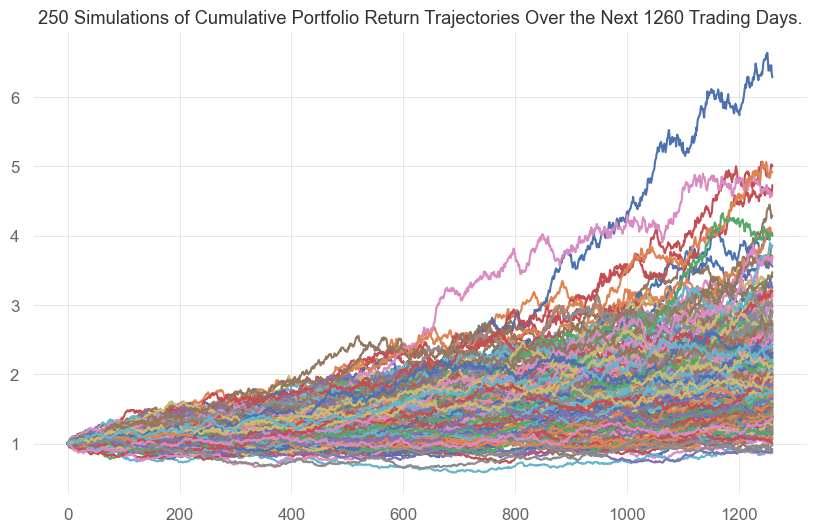

In [10]:
# Plot simulation outcomes
line_plot = MC_fiveyear.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

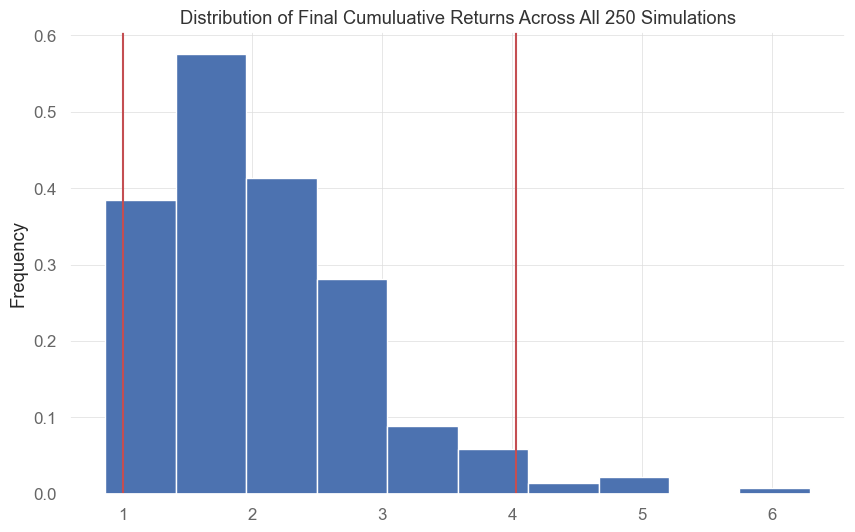

In [11]:
# Plot probability distribution and confidence intervals
dist_plot = MC_fiveyear.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

In [12]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
print (tbl)

count           250.000000
mean              2.074309
std               0.816934
min               0.868371
25%               1.509071
50%               1.932753
75%               2.502685
max               6.288273
95% CI Lower      1.005277
95% CI Upper      4.026187
Name: 1260, dtype: float64


In [13]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in Coca-Cola and Microsoft stocks
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 5 years will end within in the range of $10052.77 and $40261.87


C:\Users\rrose\AppData\Local\Temp\ipykernel_16356\3247811803.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ci_lower = round(tbl[8]*10000,2)
C:\Users\rrose\AppData\Local\Temp\ipykernel_16356\3247811803.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ci_upper = round(tbl[9]*10000,2)


In [14]:
tickers = ["XLP", "XLU", "XLV"] 
timeframe = "1Day"
start_date = pd.Timestamp("2017-01-01", tz = "America/New_York").isoformat()
end_date = pd.Timestamp("2023-11-08", tz = "America/New_York").isoformat()
contraction_etf_portfolio = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

contraction_etf_portfolio.head()

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2017-01-03 05:00:00+00:00,51.880,51.97,51.60,40287,51.75,29302665,51.831194,XLP
2017-01-04 05:00:00+00:00,51.900,52.15,51.89,31355,51.97,9611120,51.988604,XLP
2017-01-05 05:00:00+00:00,52.035,52.14,51.70,33258,51.89,14722094,52.000310,XLP
2017-01-06 05:00:00+00:00,52.120,52.15,51.78,26767,51.97,10458660,52.053496,XLP
2017-01-09 05:00:00+00:00,51.700,51.96,51.65,24679,51.92,7244465,51.734766,XLP


In [15]:
xlp = contraction_etf_portfolio[contraction_etf_portfolio["symbol"]=="XLP"].drop("symbol", axis=1)
xlv = contraction_etf_portfolio[contraction_etf_portfolio["symbol"]=="XLV"].drop("symbol", axis=1)
xlu = contraction_etf_portfolio[contraction_etf_portfolio["symbol"]=="XLU"].drop("symbol", axis=1)
contraction_etf_portfolio = pd.concat([xlp, xlv, xlu], axis=1, keys=["XLP", "XLV", "XLU"])

contraction_etf_portfolio.head()

XLP                                             \
                            close   high    low trade_count   open    volume   
timestamp                                                                      
2017-01-03 05:00:00+00:00  51.880  51.97  51.60       40287  51.75  29302665   
2017-01-04 05:00:00+00:00  51.900  52.15  51.89       31355  51.97   9611120   
2017-01-05 05:00:00+00:00  52.035  52.14  51.70       33258  51.89  14722094   
2017-01-06 05:00:00+00:00  52.120  52.15  51.78       26767  51.97  10458660   
2017-01-09 05:00:00+00:00  51.700  51.96  51.65       24679  51.92   7244465   

                                        XLV                 ...         \
                                vwap  close   high     low  ...   open   
timestamp                                                   ...          
2017-01-03 05:00:00+00:00  51.831194  69.86  69.86  69.220  ...  69.31   
2017-01-04 05:00:00+00:00  51.988604  70.39  70.58  69.950  ...  69.95   
2017-01-05 05:00:00+00:00  52.000310  70.70  70.77  70.270  ...  70.33   
2017-01-06 05:00:00+00:00  52.053496  70.95  71.15  70.515  ...  70.77   
2017-01-09 05:00:00+00:00  51.734766  71.25  71.37  70.820  ...  70.83   

                                                  XLU                    \
                             volume       vwap  close     high      low   
timestamp                                                                 
2017-01-03 05:00:00+00:00  13117758  69.660902  48.45  48.6300  48.1399   
2017-01-04 05:00:00+00:00   9281427  70.320826  48.63  48.8801  48.4301   
2017-01-05 05:00:00+00:00   6136567  70.577641  48.68  48.7600  48.1600   
2017-01-06 05:00:00+00:00   5863076  70.867066  48.83  48.9200  48.3500   
2017-01-09 05:00:00+00:00   5890843  71.171993  48.19  49.0300  48.1800   

                                                                   
                          trade_count   open    volume       vwap  
timestamp                                                          
2017-01-03 05:00:00+00:00       66089  48.50  19196984  48.371734  
2017-01-04 05:00:00+00:00       53694  48.52  14721252  48.647334  
2017-01-05 05:00:00+00:00       56436  48.74  16624379  48.527352  
2017-01-06 05:00:00+00:00       42035  48.37  11095327  48.693372  
2017-01-09 05:00:00+00:00       47950  49.01  14063306  48.436226  

[5 rows x 21 columns]

In [16]:
contraction_etf_portfolio_closing = pd.DataFrame()

for ticker in tickers:
    contraction_etf_portfolio_closing[ticker] = contraction_etf_portfolio[ticker]["close"]
    
contraction_etf_portfolio_closing.index = contraction_etf_portfolio_closing.index.date

contraction_portfolio_returns = contraction_etf_portfolio_closing.pct_change()
contraction_etf_portfolio_closing.head()

,XLP,XLU,XLV
2017-01-03,51.880,48.45,69.86
2017-01-04,51.900,48.63,70.39
2017-01-05,52.035,48.68,70.70
2017-01-06,52.120,48.83,70.95
2017-01-09,51.700,48.19,71.25


In [17]:
?MCSimulation

Init signature:
MCSimulation(
    portfolio_data,
    weights='',
    num_simulation=1000,
    num_trading_days=252,
)
Docstring:     
A Python class for runnning Monte Carlo simulation on portfolio price data. 

...

Attributes
----------
portfolio_data : pandas.DataFrame
    portfolio dataframe
weights: list(float)
    portfolio investment breakdown
nSim: int
    number of samples in simulation
nTrading: int
    number of trading days to simulate
simulated_return : pandas.DataFrame
    Simulated data from Monte Carlo
confidence_interval : pandas.Series
    the 95% confidence intervals for simulated final cumulative returns
    
Init docstring:
Constructs all the necessary attributes for the MCSimulation object.

Parameters
----------
portfolio_data: pandas.DataFrame
    DataFrame containing stock price information from Alpaca API
weights: list(float)
    A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
num_simulation: int
    Number 

In [21]:
MC_fiveyear = MCSimulation(
    portfolio_data = contraction_etf_portfolio,
    weights = [.25,.25,.5],
    num_simulation = 250,
    num_trading_days = 252*5
)

In [22]:
MC_fiveyear.portfolio_data.head()

XLP                                             \
                            close   high    low trade_count   open    volume   
timestamp                                                                      
2017-01-03 05:00:00+00:00  51.880  51.97  51.60       40287  51.75  29302665   
2017-01-04 05:00:00+00:00  51.900  52.15  51.89       31355  51.97   9611120   
2017-01-05 05:00:00+00:00  52.035  52.14  51.70       33258  51.89  14722094   
2017-01-06 05:00:00+00:00  52.120  52.15  51.78       26767  51.97  10458660   
2017-01-09 05:00:00+00:00  51.700  51.96  51.65       24679  51.92   7244465   

                                                     XLV         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-01-03 05:00:00+00:00  51.831194          NaN  69.86  69.86  ...   
2017-01-04 05:00:00+00:00  51.988604     0.000386  70.39  70.58  ...   
2017-01-05 05:00:00+00:00  52.000310     0.002601  70.70  70.77  ...   
2017-01-06 05:00:00+00:00  52.053496     0.001634  70.95  71.15  ...   
2017-01-09 05:00:00+00:00  51.734766    -0.008058  71.25  71.37  ...   

                                                     XLU                    \
                                vwap daily_return  close     high      low   
timestamp                                                                    
2017-01-03 05:00:00+00:00  69.660902          NaN  48.45  48.6300  48.1399   
2017-01-04 05:00:00+00:00  70.320826     0.007587  48.63  48.8801  48.4301   
2017-01-05 05:00:00+00:00  70.577641     0.004404  48.68  48.7600  48.1600   
2017-01-06 05:00:00+00:00  70.867066     0.003536  48.83  48.9200  48.3500   
2017-01-09 05:00:00+00:00  71.171993     0.004228  48.19  49.0300  48.1800   

                                                                                
                          trade_count   open    volume       vwap daily_return  
timestamp                                                                       
2017-01-03 05:00:00+00:00       66089  48.50  19196984  48.371734          NaN  
2017-01-04 05:00:00+00:00       53694  48.52  14721252  48.647334     0.003715  
2017-01-05 05:00:00+00:00       56436  48.74  16624379  48.527352     0.001028  
2017-01-06 05:00:00+00:00       42035  48.37  11095327  48.693372     0.003081  
2017-01-09 05:00:00+00:00       47950  49.01  14063306  48.436226    -0.013107  

[5 rows x 24 columns]

In [23]:
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 110.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 120.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 130.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 140.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 150.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 160.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 170.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 180.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 190.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 200.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 210.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 220.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 230.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

Running Monte Carlo simulation number 240.


C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\rrose\Documents\project 1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999149,1.008581,1.000753,1.005302,1.007855,1.004739,1.017839,1.009714,1.005432,1.000469,...,1.002243,1.006712,1.003016,0.988776,0.999535,1.003480,0.999332,0.995436,0.995419,1.013225
2,1.003288,1.007732,1.004939,1.009885,1.007049,0.998246,1.019084,1.007495,1.015647,1.001960,...,1.005880,1.021090,0.993733,0.998411,1.004736,1.010590,1.002480,0.993223,0.995213,1.019230
3,1.001730,1.002830,0.993455,1.020501,1.018668,1.001585,1.008971,1.004773,1.018773,1.003524,...,1.009765,1.028452,1.003486,1.003997,1.007702,1.011952,1.010081,0.991117,1.000510,1.016371
4,0.993506,1.008417,0.999560,1.013708,1.020089,0.987410,1.024197,1.002773,1.013726,1.004427,...,1.010654,1.022277,1.003586,1.006780,1.002729,1.010166,0.996901,0.996160,1.009898,1.017150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.449995,1.216197,1.390684,1.761540,1.425352,1.381767,0.953606,1.418576,1.471390,1.296166,...,0.795540,1.500564,0.993000,1.160463,1.052668,0.883204,1.328899,0.889046,1.476708,1.369947
1257,1.444008,1.196807,1.406176,1.729104,1.421294,1.383174,0.950701,1.421799,1.465093,1.285151,...,0.794604,1.504291,0.993059,1.166760,1.050872,0.874012,1.324018,0.889430,1.489167,1.365070
1258,1.451910,1.194475,1.399933,1.719493,1.424555,1.389979,0.940162,1.435425,1.469277,1.295017,...,0.794363,1.517818,0.986601,1.160100,1.053437,0.866017,1.329014,0.892913,1.477779,1.368554
1259,1.441772,1.177523,1.399920,1.730328,1.426285,1.383656,0.947208,1.443446,1.485010,1.298057,...,0.795397,1.505856,0.982444,1.162571,1.063226,0.858215,1.347349,0.893404,1.458839,1.363601


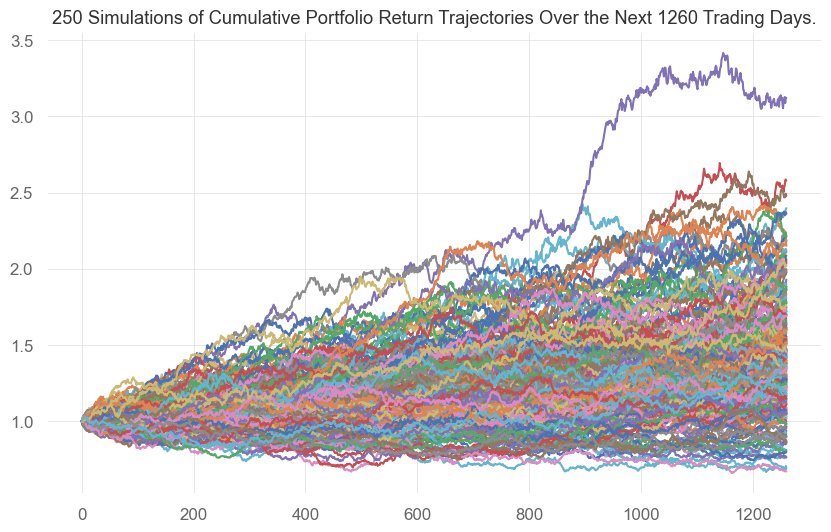

In [24]:
line_plot = MC_fiveyear.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

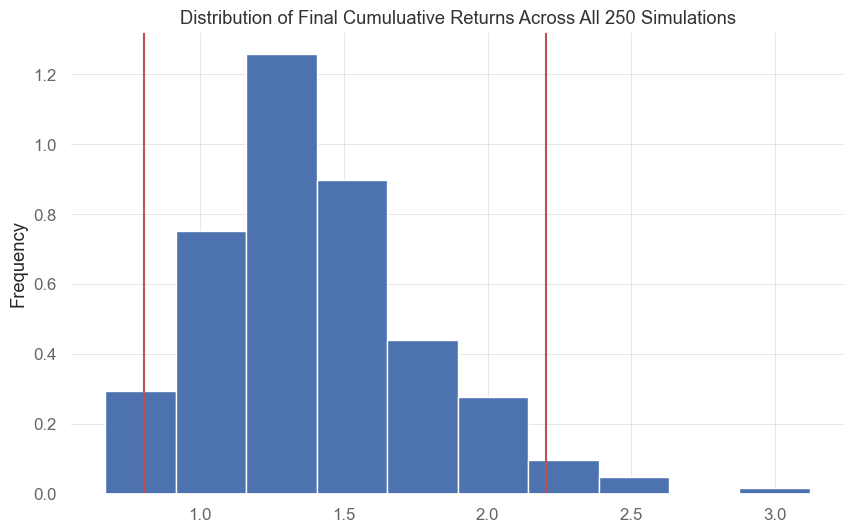

In [25]:
dist_plot = MC_fiveyear.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

In [26]:
tbl2 = MC_fiveyear.summarize_cumulative_return()

print(tbl2)

count           250.000000
mean              1.407064
std               0.376066
min               0.671974
25%               1.150722
50%               1.354604
75%               1.602976
max               3.120103
95% CI Lower      0.805476
95% CI Upper      2.203986
Name: 1260, dtype: float64


In [27]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in Coca-Cola and Microsoft stocks
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 5 years will end within in the range of $10052.77 and $40261.87


C:\Users\rrose\AppData\Local\Temp\ipykernel_16356\3247811803.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ci_lower = round(tbl[8]*10000,2)
C:\Users\rrose\AppData\Local\Temp\ipykernel_16356\3247811803.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ci_upper = round(tbl[9]*10000,2)
